In [210]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from scipy import fft

# Hypothesis Testing And Goodness of Fit
Hypothesis testing and $\chi^2$ statistics tests quantify the validity and 'goodness of fit', respectively. Again a thorough treatment of the $\chi^2$ statistic is presented in chapters 5 and 8 of 'Measurements and Their Uncertainties'{cite}`Hughes_Hase`. The statistic is defined as,  
```{math}
    \chi^2 = \sum_{i=0}^N\left(\frac{y'(\vec{x_i},\vec{p})-y(\vec{x_i})}{\alpha_i}\right)^2.
```
If each value in the residual sum is treated as an independent random variable. Then the sum of the values is distributed according to, 
```{math}
    X(\chi^2:\nu) = \frac{(\chi^2)^{\frac{\nu}{2} - 1}exp(-\chi^2/2)}{2^{\nu/2}\Gamma(\nu/2)}.
```
Both the PDF(probability density function) and CDF(cumulative density function) are plotted below left and right, respectively. The degrees of freedom, $\nu = N - m$, where N and m are the numbers of data points and parameters, respectively. 

The CDF quantifies the probability that the residuals are larger for a specific model with a $\chi^2$, $P(\chi^2 \geq \chi^2_{min};\nu)$. A good fit is indicated by a value close to one. Bearing in mind that the $\chi^2$ considers the size of the errors present. A large value for $P(\chi^2 \geq \chi^2_{min};\nu)$ can be an indication of overly large error. 

## Hypothesis Testing
Hypothesis testing provides a systematic framework for deciding if a model fits set of data. The process for the Pearson $\chi^2$ test is as follows. 

Given a null hypothesis $\mathcal{H}_0 $
1. Determine the $\chi^2$ value for the data 
2. Determine $\nu$
3. Select a confidence level and calculate $\chi^2_{crit}$ 
4. Compare The Value of $\chi^2_{min}$ with $\chi^2_{crit}$
5. Reject $\mathcal{H}_0$ if $\chi^2_{min} \geq \chi^2_{crit}$



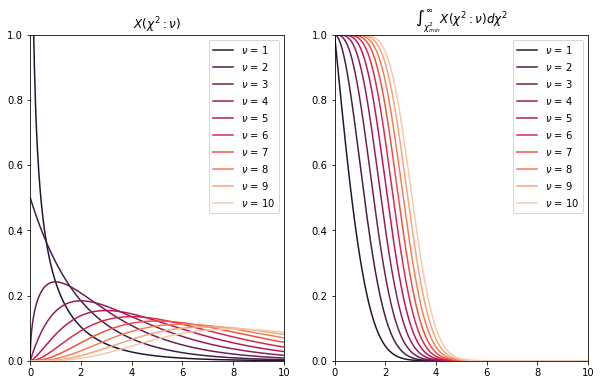

In [102]:
x = np.linspace(0, 10, 1000)
#Plotting
fig, ax  = plt.subplots(1, 2, figsize = (10,6))
for spt in ax:    
    spt.set_prop_cycle(color = sns.color_palette("rocket",10))
for i in range(10):
    pdf = stats.chi2.pdf(x, 1+i)
    cdf = stats.chi.cdf(x, 1+i)
    ax[0].plot(x, pdf, label = r'$\nu$' +f' = {i+1}')
    ax[1].plot(x, 1-cdf,label = r'$\nu$' +f' = {i+1}')
for spt in ax:
    spt.legend()
    spt.set_ylim(0, 1)
    spt.set_xlim(0, 10)
ax[0].set_title(r'$ X(\chi^2:\nu) $')
ax[1].set_title(r'$ \int_{\chi^2_{min}}^\infty X(\chi^2:\nu) d \chi^2 $')
None

## Implementing $\chi^2$ testing in $CO_2$ data

In [71]:
path_global = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv'
co2_data_global = pd.read_csv(path_global, header=0, comment='#')
path_ml =  'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'              
co2_data_ml = pd.read_csv(path_ml, header=0, comment='#')
co2_data_ml = co2_data_ml[co2_data_ml['sdev']>0] 

In [186]:
# Probably should have defined a function that returns values.
def p3(x, a_0, a_1, a_2, a_3):
    return a_0 + a_1*x + a_2*x**2 + a_3*x**3 

def p1(x, a_0, a_1):
    return a_0 + a_1*x
# Fit Coefs
##Unweighted Least Squares Global
p1_global_fit, p1_global_error = scipy.optimize.curve_fit(p1,
    co2_data_global['decimal'],
    co2_data_global['average']
    )
#chisq
y_p1_global = p1(co2_data_global['decimal'], *p1_global_fit)
rs_global_p1 = y_p1_global-co2_data_global['average']
chisq_global_p1 = np.sum(((rs_global_p1)
    / np.mean(co2_data_global['decimal']**2)**0.5)**2
    )
#P3
p3_global_fit, p3_global_error = scipy.optimize.curve_fit(p3,
    co2_data_global['decimal'],
    co2_data_global['average']
    )
#chisq
y_p3_global = p3(co2_data_global['decimal'], *p3_global_fit)
rs_global_p3 = y_p3_global-co2_data_global['average']
chisq_global_p3 = np.sum(((rs_global_p3)
    / np.mean(co2_data_global['decimal']**2)**0.5)**2
    )
# Weighted Least Squares Mauna Loa 
p1_ml_fit, p1_ml_error = scipy.optimize.curve_fit(p1,
    co2_data_ml['decimal date'],
    co2_data_ml['average'],
    sigma = co2_data_ml['sdev']
    )
y_p1_ml = p1(co2_data_ml['decimal date'], *p1_ml_fit)
rs_ml_p1 = y_p1_ml-co2_data_ml['average']
chisq_ml_p1 = np.sum(((rs_ml_p1)
    / co2_data_ml['sdev'])**2
    )
#P3
p3_ml_fit, p3_ml_error = scipy.optimize.curve_fit(p3,
    co2_data_ml['decimal date'],
    co2_data_ml['average'],
    sigma = co2_data_ml['sdev']
    )
#chisq
y_p3_ml = p3(co2_data_ml['decimal date'], *p3_ml_fit)
rs_ml_p3 = y_p3_ml-co2_data_ml['average']
chisq_ml_p3 = np.sum(((rs_ml_p3)
    / co2_data_ml['sdev'])**2
    )

## Calculating $P(\chi^2 \geq \chi^2_{min};\nu)$

In [190]:
nu_p1_ml = co2_data_ml['average'].shape[0] - len(p1_ml_fit)
nu_p3_ml = co2_data_ml['average'].shape[0] - len(p3_ml_fit)
p_ml_p1 = stats.chi2.sf(chisq_ml_p1,nu_p1_ml)
p_ml_p3 = stats.chi2.sf(chisq_ml_p3,nu_p3_ml)
print(rf'P(\chi^2 \geq \chi^2_{{min}};{nu_p1_ml}) = {p_ml_p1}')
print(rf'P(\chi^2 \geq \chi^2_{{min}};{nu_p3_ml}) = {p_ml_p3}')

P(\chi^2 \geq \chi^2_{min};573) = 0.0
P(\chi^2 \geq \chi^2_{min};571) = 0.0


Text(0.5, 1.0, 'Global Average')

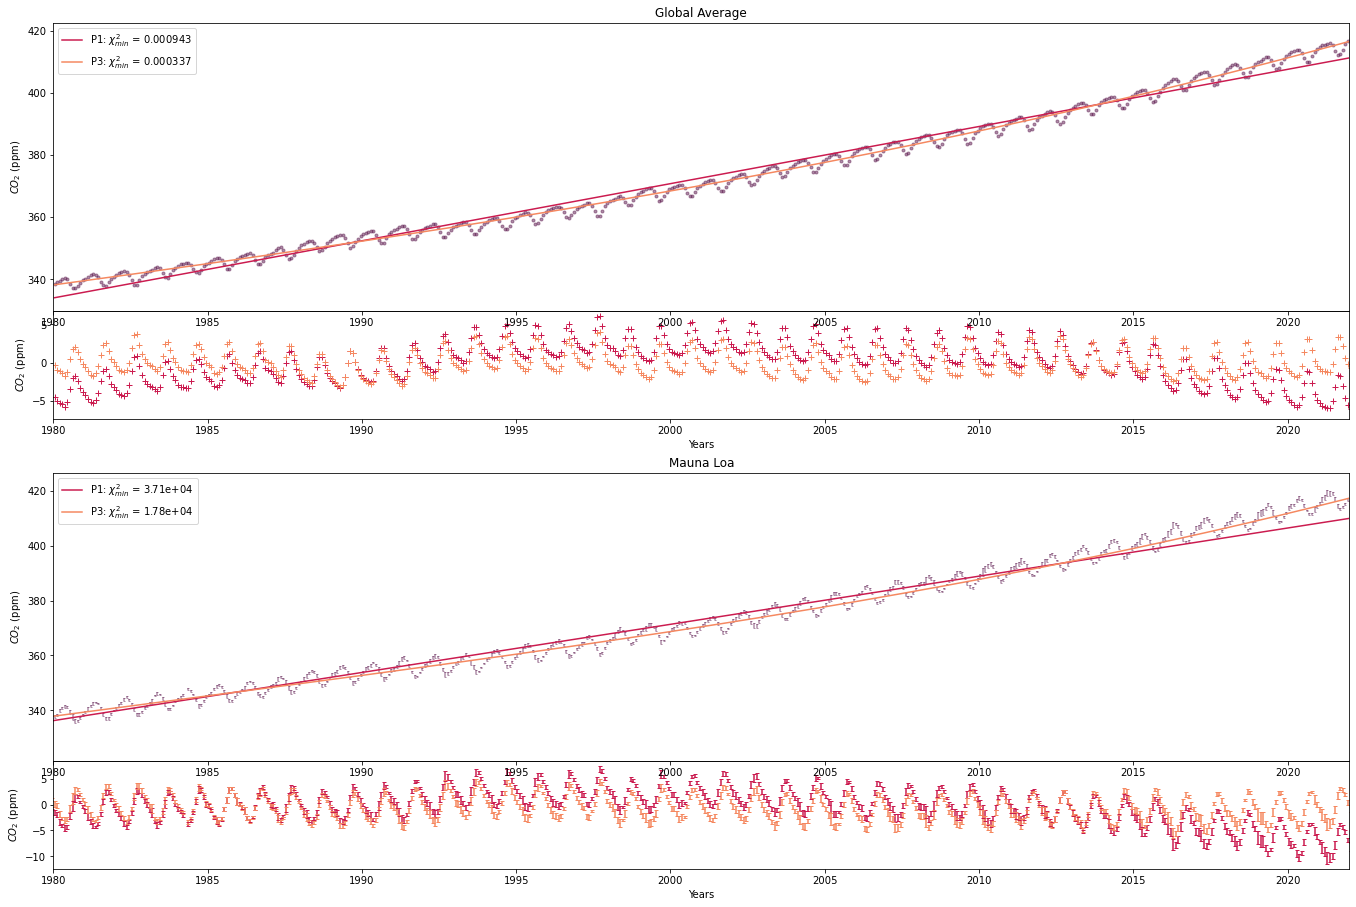

In [209]:
# Building Subplot list, add axis builds from bottom left
total_fig_height = 3
total_fig_width = 3
fig = plt.figure()
ax = []
current_fig_bottom = 0
for i in range(4):
    if i%2 != 0:
        height = total_fig_height/3
        
        ax.append(fig.add_axes([0,current_fig_bottom, total_fig_width, height]))
        current_fig_bottom += height + total_fig_height/16
    else:
        height = total_fig_height/8
        ax.append(fig.add_axes([0,current_fig_bottom, total_fig_width, height]))
        current_fig_bottom += height  
# Lists for plotting
#glob
fits_global = [y_p1_global, y_p3_global]
chisq_global = [chisq_global_p1, chisq_global_p3]
rs_glob = [rs_global_p1,rs_global_p3]
glob = zip(fits_global, chisq_global,rs_glob)
#ml
fits_ml = [y_p1_ml, y_p3_ml]
chisq_ml = [chisq_ml_p1, chisq_ml_p3]
rs_ml = [rs_ml_p1, rs_ml_p3]
ml = zip(fits_ml,chisq_ml,rs_ml)
#Plotting
for i, spt in enumerate(ax):
    spt.set_ylabel(r'$CO_2$ (ppm)')
    if i%2 != 0:
        spt.set_prop_cycle(color = 
        sns.color_palette("rocket",3)
        )
    else:
        cp = sns.color_palette("rocket",3)
        cp.pop(0)
        spt.set_prop_cycle(color = cp)
    
    spt.set_xlim(1980,2022)
ax[3].plot(co2_data_global['decimal'],
    co2_data_global['average'],
    linestyle = '',
    marker = '.',
    alpha = 0.5
    )    
ax[1].errorbar(co2_data_ml['decimal date'],
    co2_data_ml['average'],
    co2_data_ml['sdev'],
    linestyle = '',
    capsize = 1,
    alpha = 0.5
    )   
for i, ((glob_f, glob_chi,residual_global), (ml_f, ml_chi,residual_ml)) in enumerate(zip(glob,ml)):
    #ml plot 
    ax[1].plot(co2_data_ml['decimal date'],ml_f,
    label = f'P{2*i + 1}: '+ r'$\chi^2_{min}$ = '+f'{ml_chi:.3}'
    )
    ax[0].errorbar(co2_data_ml['decimal date'],
    residual_ml,
    co2_data_ml['sdev'],
    linestyle = '',
    capsize = 2
    )
    #global
    ax[3].plot(co2_data_global['decimal'],glob_f,
    label = f'P{2*i + 1}: ' + r'$\chi^2_{min}$ = '+f'{glob_chi:.3}'
    )
    ax[2].plot(co2_data_global['decimal'],
    residual_global,
    marker = '+',
    linestyle = ''
    )

ax[1].legend()
ax[3].legend()
ax[0].set_xlabel('Years')
ax[2].set_xlabel('Years')
ax[1].set_title('Mauna Loa')
ax[3].set_title('Global Average')

The $P(\chi^2 \geq \chi^2_{min};\nu) = 0.0$, values are infact expected. On inspection, the error on each measurment is of the order $0.1$ ppm. However, the magnitude of the residuals, regularly is of the order $1$ ppm. As such, the fit to the Mauna Loa Data should be poor. The residuals also have a regular periodic structure. A Fourier transform can be used to determine the periodicity of the residuals. A better model can be made with the form of the periodic part of the function.  

## Fourier Transforms
There are whole texts dedicated to the subtleties of Fourier analysis. For an intuitive picture of how the technique works, this [video](https://www.youtube.com/watch?v=spUNpyF58BY)](https://www.youtube.com/watch?v=spUNpyF58BY) is excellent. 

The 1D Fourier and inverse Fourier transforms are defined as integrals over all real numbers. The precise definition of the transform can vary. However, the general form of transform and its inverse are respectively
```{math}
    \mathcal{F}[f(t)](\omega) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} f(t) e^{-i \omega t}dt,  \\
    \mathcal{F^{-1}}[f(\omega)](t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} f(t) e^{i \omega t}d\omega.
```
Clearly with, the discrete data provided by the residuals, such definitions must be adjusted. Due to problems of this form being common across many disciplines, the Fast Fourier transform(FFT){cite}`FFT` was developed to perform these calculations efficiently. Additionally,  a Discrete Cosine Transform(DCT){cite}`DCT` can be used because the data is real-valued. 